In [183]:
from process_data import clean_data, create_index, pivot_data, clean_data2
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [184]:
def data_lstm(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i+lookback])
    return np.array(newX), np.array(newY)

def data_mimo(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i:i+1+lookback])
    return np.array(newX), np.array(newY)



def mlp(lookback,num_features):
    model = Sequential()
    model.add(TimeDistributed(Dense(lookback+1,activation='tanh'), input_shape=(lookback+1,num_features)))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(lookback+1,activation='tanh')))
    model.add(TimeDistributed(Dense(1,activation='linear')))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

def create_rnn_back(lookback,num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=16, stateful=True))
    #model.add(Dropout(0.05))

    model.add(LSTM(units=8,return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=4,stateful=True))
    #model.add(Dropout(0.05))
    
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model

def create_rnn(lookback,num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=16, stateful=True))
    #model.add(Dropout(0.05))

    model.add(LSTM(units=8,return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=4,stateful=True))
    #model.add(Dropout(0.05))
    
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model

def train_rnn(df,date_predict,lookback,epochs=100):
    #Preparting data to Train
    print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=60+lookback//24)).strftime('%Y-%m-%d')
    sk = df[:date_limit].copy()
    print(sk.shape)
    sk = sk.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #sk.hourofday = sk.hourofday.dt.seconds/3600
    sk = sk[date_start:]
    #sk = sk[24:]
    print('Shape os SK:',sk.shape)
    y = sk.pop('DAENERGY').values
    X = sk.values[:,1:]
    X, y = data_mimo(X,y,lookback)
    y = y.reshape(len(y),y.shape[1],1)
    print('Shape of X',X.shape)
    #X = X[1:]
    #y = y[1:]
    print('Shape of X',X.shape)
    print('YYYY')
    print(y.shape)
    
    model = mlp(lookback,X.shape[2])
    #model = create_rnn(lookback,X.shape[2])

    #X = X.reshape(X.shape[0],X.shape[1],1)
    filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
    filepath="best_model_mlp-mimo.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
    tensorboard = TensorBoard(log_dir='./logs/mlp'+str(time.time()), 
                              histogram_freq=0, 
                              batch_size=24, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=True, 
                              )
    # #Training Model
    model.fit(
        X,
        y,
        batch_size=24,  #168, 
        epochs=epochs,
        shuffle = False,
        validation_split=0.1, callbacks=[tensorboard, checkpoint, early_stop])  #0.0857 #0.05 #0.1

    #preparing data to Predict
    return model, X, y

def predict_day(date_predict,model,lookback=168):
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

    df_predict = df.copy()
    df_predict = df_predict[:date_predict]

    df_predict = df_predict.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #df_predict.hourofday = df_predict.hourofday.dt.seconds/3600
    df_predict = df_predict[date_start:]
    y = df_predict.pop('DAENERGY').values
    X = df_predict.values[:,1:]
    #X,y = data_lstm(X,y,lookback)
    X,y = data_mimo(X,y,lookback)
    input_p = X[-24:]   #-24
    input_p = X[-1:]
    pred = model.predict(input_p,batch_size=1)

    results = df[date_predict].copy()
    # pred_ada = model.predict(input_p.values)
    results['forecast'] = pred[0]
    RMSE = get_rmse(results['DAENERGY'].values, pred)
    return results, RMSE

def plot_results(results,date_predict):
    RMSE = get_rmse(results['DAENERGY'], results['forecast'])
    fig, ax = plt.subplots(figsize=(9,4))
    # npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')
    #
    # # Plot data points
    results['DAENERGY'].plot(ax=ax, style='o', label='Observed')
    #
    # # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    # #ci = predict_ci.loc[date_predict]
    # #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')


def get_rmse(pred,real):
    return np.sqrt(((pred-real)**2).sum()/pred.shape[0])

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates


def create_features(df):
    df = df.copy()
    features = ['Ph-1', 'Ph-2', 'Ph-3', 'Ph-24', 'Ph-25', 'Ph-48', 'Ph-49',
                'Ph-72','Ph-73', 'Ph-96', 'Ph-97', 'Ph-120', 'Ph-121', 'Ph-144',
                'Ph-145', 'Ph-168']
    deltas = [1, 2, 3, 24, 25, 48, 49, 72, 73, 96, 97, 120, 121, 144, 145, 168]

    for col, shift in zip(features, deltas):
        df[col] = df.DAENERGY.shift(shift)
    return df

def create_rollings(df):
    df = df.copy()
    means_cols = ['mean_3','mean_6','mean_9','mean_12','mean_24']
    means_values = [3,6,9,12,24]
    
    for col, val in zip(means_cols, means_values):
        df[col] = pd.Series.rolling(df.DAENERGY, window=val, center = False).mean()
        df[col] = df[col].shift(24)
    
    #df['p_1'] = df.DAENERGY.shift(1)
    df['p_24'] = df.DAENERGY.shift(24)
    df['p_48'] = df.DAENERGY.shift(48)
    return df        

def MAPE(y_true, y_pred):
    return 1.0/len(y_true)*(np.abs((y_true-y_pred))/y_true*100).sum()

from keras.optimizers import RMSprop, Adam, Adadelta

def create_rnn_2(lookback, num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=20, stateful=True))
    model.add(Dropout(0.5))

    model.add(LSTM(units=20,return_sequences=False, stateful=True))
    model.add(Dropout(0.5))
    
    #model.add(LSTM(units=20,stateful=False))
    #model.add(Dropout(0.5))
    
    model.add(Dense(units=10))
    model.add(Activation('linear'))

    model.add(Dense(units=1))
    model.add(Activation('linear'))

    #optim = RMSprop(lr=0.01)
    #optim = Adadelta()
    start = time.time()
    model.compile(loss='mse', optimizer = 'adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model

def create_nn(lookback, num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=20, stateful=False))
    model.add(Dropout(0.1))

    model.add(LSTM(units=20,return_sequences=False, stateful=False))
    model.add(Dropout(0.5))
    
    #model.add(LSTM(units=20,stateful=False))
    #model.add(Dropout(0.5))
    
    model.add(Dense(units=10))
    model.add(Activation('linear'))

    model.add(Dense(units=1))
    model.add(Activation('linear'))

    #optim = RMSprop(lr=0.01)
    #optim = Adadelta()
    start = time.time()
    model.compile(loss='mse', optimizer = 'adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model

In [185]:
df = pivot_data('../data/Data.txt')
#scaler = MinMaxScaler(feature_range=(-1,1)).fit(df.DAENERGY)
#df.DAENERGY = scaler.transform(df.DAENERGY)
df = clean_data(df)
df = create_index(df)
df2 = pivot_data('../data/FurtherBack.txt','2017-05-15','2017-07-07')
df2 = clean_data2(df2)
df2 = create_index(df2)
df = pd.concat([df2,df])


df = create_rollings(df)
df = df.dropna()

wdf = pd.read_csv('../data/wstation.csv', delim_whitespace=True)
temp_cols = []
cols = df.columns.values
for col in cols:
    if len(col)==4 and col not in ['LOAD', 'p_48', 'p_72']:
        temp_cols.append(col)
        
wdf = wdf.drop_duplicates(subset = ['CALL'])

temps = pd.DataFrame(temp_cols)
temps.columns = ['CALL']
result = pd.merge(temps, wdf, how='left', on=['CALL'])
result = result[['CALL','LAT','LON']]
result = result.dropna()

from sklearn.cluster import KMeans
clusters = KMeans(n_clusters = 4).fit(result[['LAT','LON']])

result['Cluster'] = clusters.labels_

df['Temp_C_0']=df[result[result.Cluster==0]['CALL']].mean(axis=1)
df['Temp_C_1']=df[result[result.Cluster==1]['CALL']].mean(axis=1)
df['Temp_C_2']=df[result[result.Cluster==2]['CALL']].mean(axis=1)
df['Temp_C_3']=df[result[result.Cluster==3]['CALL']].mean(axis=1)

df = df.drop(temp_cols, axis=1)


list_scalers = dict()
for c in df.columns.values:
    list_scalers[c] = MinMaxScaler()
    list_scalers[c].fit(df[c].values.reshape(-1,1))
    df[c] = list_scalers[c].transform(df[c].values.reshape(-1,1))


print('Training the model...')

lookback=23#72#48#168

Training the model...


In [186]:
lookback=23

In [187]:
#df.DAENERGY = list_scalers['DAENERGY'].inverse_transform(df.DAENERGY.values)
start = time.time()
model, X, y = train_rnn(df,'2017-09-27',lookback=23,epochs=500)
print('Training time : {}'.format(time.time() - start))

Preparing data to Train
(3239, 18)
('Shape os SK:', (1440, 16))
('Shape of X', (1417, 24, 14))
('Shape of X', (1417, 24, 14))
YYYY
(1417, 24, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, 24, 24)            360       
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 24, 24)            600       
_________________________________________________________________
time_distributed_52 (TimeDis (None, 24, 1)             25        
Total params: 985
Trainable params: 985
Non-trainable params: 0
_________________________________________________________________
Train on 1275 samples, validate on 142 samples
Epoch 1/500
1275/1275 [==============================] - 0s - loss: 0.0376 - val_los

1275/1275 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0296
Epoch 29/500
1275/1275 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0295
Epoch 30/500
1275/1275 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0291
Epoch 31/500
1275/1275 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0290
Epoch 32/500
1275/1275 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0289
Epoch 33/500
1275/1275 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0281
Epoch 34/500
1275/1275 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0280
Epoch 35/500
1275/1275 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0277
Epoch 36/500
1275/1275 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0273
Epoch 37/500
1275/1275 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0268
Epoch 38/500
1275/1275 [==============================] - 0s - 

1275/1275 [==============================] - 0s - loss: 7.5142e-04 - val_loss: 0.0206
Epoch 61/500
1275/1275 [==============================] - 0s - loss: 7.4032e-04 - val_loss: 0.0203
Epoch 62/500
1275/1275 [==============================] - 0s - loss: 7.4845e-04 - val_loss: 0.0199
Epoch 63/500
1275/1275 [==============================] - 0s - loss: 7.1808e-04 - val_loss: 0.0200
Epoch 64/500
1275/1275 [==============================] - 0s - loss: 7.2152e-04 - val_loss: 0.0200
Epoch 65/500
1275/1275 [==============================] - 0s - loss: 6.9676e-04 - val_loss: 0.0195
Epoch 66/500
1275/1275 [==============================] - 0s - loss: 6.9654e-04 - val_loss: 0.0193
Epoch 67/500
1275/1275 [==============================] - 0s - loss: 6.8439e-04 - val_loss: 0.0194
Epoch 68/500
1275/1275 [==============================] - 0s - loss: 6.8884e-04 - val_loss: 0.0183
Epoch 69/500
1275/1275 [==============================] - 0s - loss: 6.4417e-04 - val_loss: 0.0184
Epoch 70/500
1275/1275 

1275/1275 [==============================] - 0s - loss: 4.6747e-04 - val_loss: 0.0155
Epoch 96/500
1275/1275 [==============================] - 0s - loss: 4.7139e-04 - val_loss: 0.0152
Epoch 97/500
1275/1275 [==============================] - 0s - loss: 4.7632e-04 - val_loss: 0.0150
Epoch 98/500
1275/1275 [==============================] - 0s - loss: 4.7892e-04 - val_loss: 0.0147
Epoch 99/500
1275/1275 [==============================] - 0s - loss: 4.7285e-04 - val_loss: 0.0143
Epoch 100/500
1275/1275 [==============================] - 0s - loss: 4.4532e-04 - val_loss: 0.0151
Epoch 101/500
1275/1275 [==============================] - 0s - loss: 4.6713e-04 - val_loss: 0.0139
Epoch 102/500
1275/1275 [==============================] - 0s - loss: 4.4895e-04 - val_loss: 0.0145
Epoch 103/500
1275/1275 [==============================] - 0s - loss: 4.5412e-04 - val_loss: 0.0147
Epoch 104/500
1275/1275 [==============================] - 0s - loss: 4.5762e-04 - val_loss: 0.0139
Epoch 105/500
1275

1275/1275 [==============================] - 0s - loss: 4.2185e-04 - val_loss: 0.0138
Epoch 133/500
1275/1275 [==============================] - 0s - loss: 4.1139e-04 - val_loss: 0.0137
Epoch 134/500
1275/1275 [==============================] - 0s - loss: 4.1491e-04 - val_loss: 0.0132
Epoch 135/500
1275/1275 [==============================] - 0s - loss: 4.1056e-04 - val_loss: 0.0134
Epoch 136/500
1275/1275 [==============================] - 0s - loss: 4.1873e-04 - val_loss: 0.0138
Epoch 137/500
1275/1275 [==============================] - 0s - loss: 4.1130e-04 - val_loss: 0.0137
Epoch 138/500
1275/1275 [==============================] - 0s - loss: 4.0644e-04 - val_loss: 0.0137
Epoch 139/500
1275/1275 [==============================] - 0s - loss: 4.1846e-04 - val_loss: 0.0131
Epoch 140/500
1275/1275 [==============================] - 0s - loss: 4.0580e-04 - val_loss: 0.0137
Epoch 141/500
1275/1275 [==============================] - 0s - loss: 4.1251e-04 - val_loss: 0.0138
Epoch 142/500


In [188]:
model = load_model('best_model_mlp-mimo.hdf5')

In [189]:
%matplotlib inline

MAPE mean:5.76


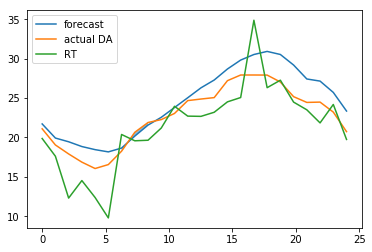

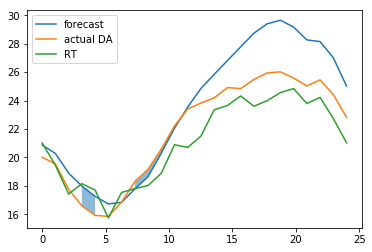

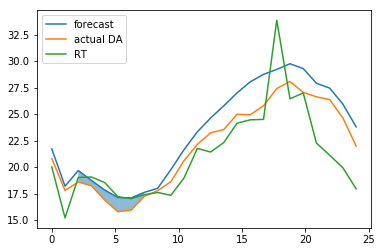

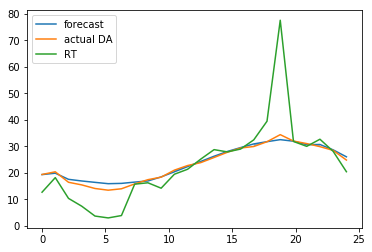

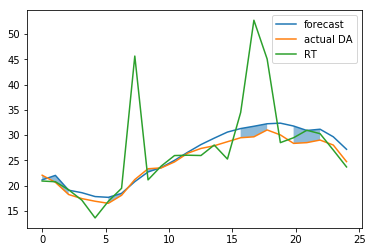

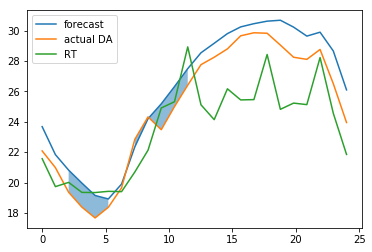

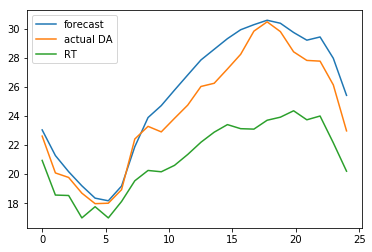

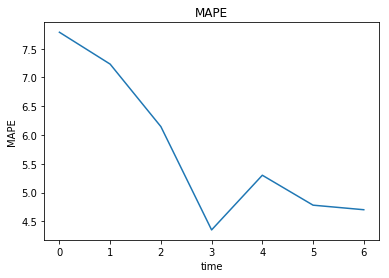

In [190]:
MAPEs = []
for day in create_date_range('2017-09-01','2017-09-07'):
    #print(day)
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    #results.DAENERGY.plot()
    #results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
    y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
    X  = np.linspace(0,24,24)
    plt.plot(X,y_pred, label='forecast')
    plt.plot(X,y_true, label='actual DA')
    plt.plot(X,y_rt, label='RT')
    plt.legend(loc='best')
    y_true =y_true.reshape(24)
    y_pred = y_pred.reshape(24)
    y_rt = y_rt.reshape(24)
    mask = ((y_rt > y_true) & (y_pred > y_true)) | ((y_rt < y_true) & (y_pred < y_true))
    plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=mask, alpha = 0.5)


plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:9.08


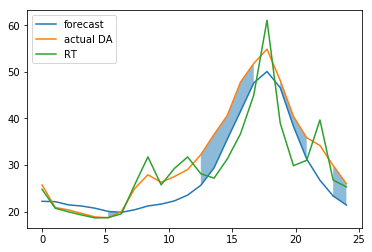

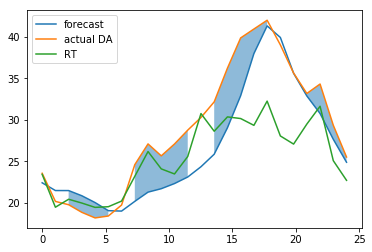

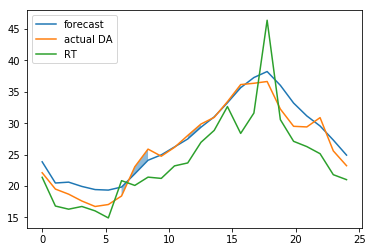

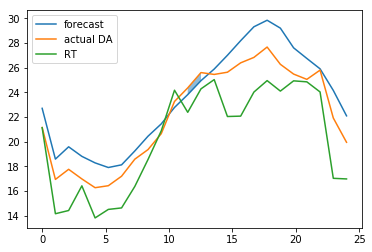

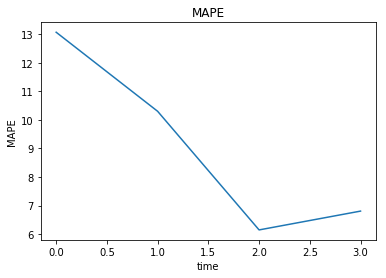

In [191]:
MAPEs=[]
for day in create_date_range('2017-09-27','2017-09-30'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    #results.DAENERGY.plot()
    #results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
    y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
    X  = np.linspace(0,24,24)
    plt.plot(X,y_pred, label='forecast')
    plt.plot(X,y_true, label='actual DA')
    plt.plot(X,y_rt, label='RT')
    plt.legend(loc='best')
    y_true =y_true.reshape(24)
    y_pred = y_pred.reshape(24)
    y_rt = y_rt.reshape(24)
    mask = ((y_rt > y_true) & (y_pred > y_true)) | ((y_rt < y_true) & (y_pred < y_true))
    plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=mask, alpha = 0.5)
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:10.11


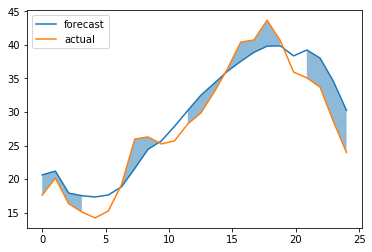

In [192]:
MAPEs=[]
day ='2017-10-02'
results, rmse = predict_day(day,model,lookback)
plt.figure()
#results.DAENERGY.plot()
#results.forecast.plot()
#results.RTENERGY.plot()
y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
X  = np.linspace(0,24,24)
plt.plot(X,y_pred, label='forecast')
plt.plot(X,y_true, label = 'actual')
#plt.plot(X,y_rt)
plt.legend()
plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=y_rt.reshape(24) <= y_true.reshape(24), alpha = 0.5)

MAPEs.append(MAPE(y_true, y_pred))

print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))